# DataKind Red Cross Project Phase 2
## Home Fire Risk Data Model

## Exploratory Data Analysis of NFIRS and SVI Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

# 1. Data Import and Cleaning

## 1.1 NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [2]:
nfirs_path = '../data/raw/NFIRS_2009_2016_Combined_Census_Tract.csv'

cols_to_use = ['state','fdid','city','zip5','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

C:\Users\thwhi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Fix the tot_loss column which had incorrect data for 2015. Since tot_loss = prop_loss + cont_loss, it was easy enough to recalculate those values
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

In [4]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [5]:
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

In [6]:
nfirs.sample(5)

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire,had_inj,had_death,10k_loss
44964,GA,6001,ATL,30300,2009-11-22,0.0,0.0,0.0,0.0,0.0,NaN,not_sev_fire,no_inj,no_death,no_10k_loss
1534409,NY,24001,New York City,10456,2015-04-02,NaN,NaN,0.0,0.0,0.0,36005013500.0,not_sev_fire,no_inj,no_death,no_10k_loss
923119,OR,193,Lake Oswego,97034,2012-04-08,NaN,NaN,40.0,0.0,40.0,41005020403.0,not_sev_fire,no_inj,no_death,no_10k_loss
209945,TX,RN502,BELLMEAD,76705,2009-06-09,0.0,0.0,0.0,0.0,0.0,48309001700.0,not_sev_fire,no_inj,no_death,no_10k_loss
1741175,MI,4112,GRAND RAPIDS,49508,2016-07-13,NaN,NaN,0.0,0.0,0.0,26081004600.0,not_sev_fire,no_inj,no_death,no_10k_loss


## 1.2 Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [7]:
nfirs['GEOID'].str.len().value_counts()

13.0    1442479
12.0     196432
Name: GEOID, dtype: int64

In [8]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2]
                  .str.zfill(11))

In [9]:
nfirs.head()

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire,had_inj,had_death,10k_loss
0,AK,11100,JUNEAU,99801,2009-01-03,0.0,0.0,20000.0,5000.0,25000.0,02110000500,sev_fire,no_inj,no_death,had_10k_loss
1,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,0.0,0.0,0.0,02110000600,not_sev_fire,no_inj,no_death,no_10k_loss
2,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,20000.0,5000.0,25000.0,02110000100,sev_fire,no_inj,no_death,had_10k_loss
3,AK,11100,JUNEAU,99801,2009-01-13,0.0,0.0,200.0,20.0,220.0,02110000400,not_sev_fire,no_inj,no_death,no_10k_loss
4,AK,11100,JUNEAU,99801,2009-01-21,0.0,0.0,35000.0,5000.0,40000.0,02110000400,sev_fire,no_inj,no_death,had_10k_loss


In [10]:
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year

## 1.3 SVI Data

In [11]:
svi2016_path = '../data/raw/SVI2016_US.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)

In [12]:
svi2016.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.644448,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,335.0
1,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.929908,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0
2,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0


# 2. Tasks 1 & 3

- Task 1: <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 3: <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.

In [13]:
# add the state+county unique identifier column to nfirs
nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_counties = pd.crosstab(nfirs['STCNTY'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_counties[(year,'tot_fires')] = nfirs_counties[(year,'not_sev_fire')] + nfirs_counties[(year,'sev_fire')]

# Sort the columns
nfirs_counties = nfirs_counties[sorted(nfirs_counties.columns)]

# aggregate svi data by county
svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_counties_rates = nfirs_svi_counties[['E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_counties_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_counties[(year,'tot_fires')] / nfirs_svi_counties['E_TOTPOP']
    nfirs_svi_counties_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_counties[(year,'sev_fire')] / nfirs_svi_counties['E_TOTPOP']

# Add the county and state columns to the dataset
nfirs_svi_counties_rates = nfirs_svi_counties_rates.merge(svi2016[['COUNTY','ST_ABBR','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
nfirs_svi_counties_rates = nfirs_svi_counties_rates.set_index('STCNTY')

# create list of severe columns & total columns
sev_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].mean(axis=1)
nfirs_svi_counties_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].std(axis=1)
nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].mean(axis=1)
nfirs_svi_counties_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_counties_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_counties_rates = nfirs_svi_counties_rates[cols]

C:\Users\thwhi\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [14]:
nfirs_svi_counties_rates.head()

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
01001,AL,Autauga,55049.0,0.000459,0.000164,0.000123,0.000070,0.000708,0.000236,0.000490,0.000163,0.000527,0.000127,0.000254,0.000036,0.000436,0.000073,0.000200,0.000036,0.000563,0.000163,0.000490,0.000145
01003,AL,Baldwin,199510.0,0.000465,0.000099,0.000082,0.000023,0.000366,0.000080,0.000471,0.000075,0.000381,0.000100,0.000441,0.000065,0.000396,0.000050,0.000677,0.000125,0.000501,0.000085,0.000486,0.000075
01005,AL,Barbour,26614.0,0.000244,0.000143,0.000070,0.000093,0.000376,0.000113,0.000451,0.000000,0.000150,0.000000,0.000301,0.000188,0.000038,0.000000,0.000338,0.000225,0.000113,0.000000,0.000188,0.000038
01007,AL,Bibb,22572.0,0.000072,0.000062,0.000033,0.000031,0.000044,0.000044,0.000044,0.000044,0.000089,0.000044,0.000177,0.000044,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000133,0.000089
01009,AL,Blount,57704.0,0.000390,0.000196,0.000095,0.000060,0.000364,0.000069,0.000399,0.000069,0.000468,0.000243,0.000277,0.000087,0.000208,0.000069,0.000295,0.000069,0.000277,0.000069,0.000832,0.000087


1. Are the per capita fire rates for the various counties normally distributed?
    - No

Text(0.5, 0, 'Rate')

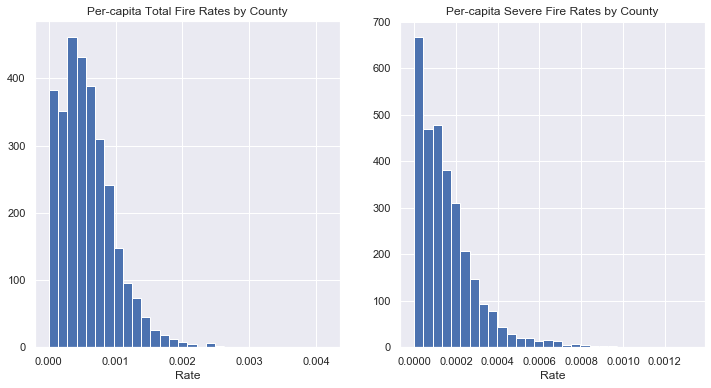

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches((12,6))

nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'].hist(bins=30, ax=ax1)
ax1.set_title('Per-capita Total Fire Rates by County')
ax1.set_xlabel('Rate')

nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'].hist(bins=30,ax=ax2)
ax2.set_title('Per-capita Severe Fire Rates by County')
ax2.set_xlabel('Rate')

### 2. Is the difference in per-capita fire rates from year to year statistically significant?
    - 2015 vs 2016: Yes.

In [16]:
from scipy import stats

stats.ttest_rel(nfirs_svi_counties_rates['2015_tot_fire_rate_per_cap'],
                nfirs_svi_counties_rates['2016_tot_fire_rate_per_cap'],nan_policy='omit')

Ttest_relResult(statistic=-4.535322662882748, pvalue=5.976114971854253e-06)

### 3. Total & Severe Fires by year

In [17]:
nfirs_svi_counties.head()

,E_TOTPOP,"(2009, not_sev_fire)","(2009, sev_fire)","(2009, tot_fires)","(2010, not_sev_fire)","(2010, sev_fire)","(2010, tot_fires)","(2011, not_sev_fire)","(2011, sev_fire)","(2011, tot_fires)","(2012, not_sev_fire)","(2012, sev_fire)","(2012, tot_fires)","(2013, not_sev_fire)","(2013, sev_fire)","(2013, tot_fires)","(2014, not_sev_fire)","(2014, sev_fire)","(2014, tot_fires)","(2015, not_sev_fire)","(2015, sev_fire)","(2015, tot_fires)","(2016, not_sev_fire)","(2016, sev_fire)","(2016, tot_fires)"
STCNTY,,,,,,,,,,,,,,,,,,,,,,,,,
01001,55049.0,26.0,13.0,39.0,18.0,9.0,27.0,22.0,7.0,29.0,12.0,2.0,14.0,20.0,4.0,24.0,9.0,2.0,11.0,22.0,9.0,31.0,19.0,8.0,27.0
01003,199510.0,57.0,16.0,73.0,79.0,15.0,94.0,56.0,20.0,76.0,75.0,13.0,88.0,69.0,10.0,79.0,110.0,25.0,135.0,83.0,17.0,100.0,82.0,15.0,97.0
01005,26614.0,7.0,3.0,10.0,12.0,0.0,12.0,4.0,0.0,4.0,3.0,5.0,8.0,1.0,0.0,1.0,3.0,6.0,9.0,3.0,0.0,3.0,4.0,1.0,5.0
01007,22572.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,2.0,3.0
01009,57704.0,17.0,4.0,21.0,19.0,4.0,23.0,13.0,14.0,27.0,11.0,5.0,16.0,8.0,4.0,12.0,13.0,4.0,17.0,12.0,4.0,16.0,43.0,5.0,48.0


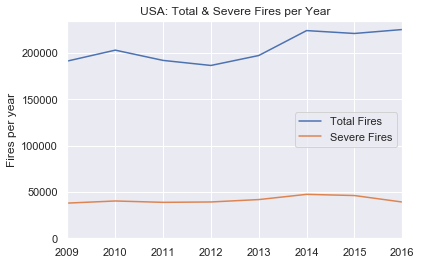

In [18]:
# Total Fires by Year for entire USA
years = list(range(2009,2017))
total_cols = [(year,'tot_fires') for year in years]
severe_cols = [(year,'sev_fire') for year in years]

fig,ax = plt.subplots()
nfirs_svi_counties[total_cols].sum().plot(ax=ax)
nfirs_svi_counties[severe_cols].sum().plot(ax=ax)
ax.set_ylim(0)
ax.legend(['Total Fires','Severe Fires'])
ax.set_ylabel('Fires per year')
ax.set_title('USA: Total & Severe Fires per Year')
a=ax.set_xticklabels(years)

# 3b. Total & Severe fires by state and year

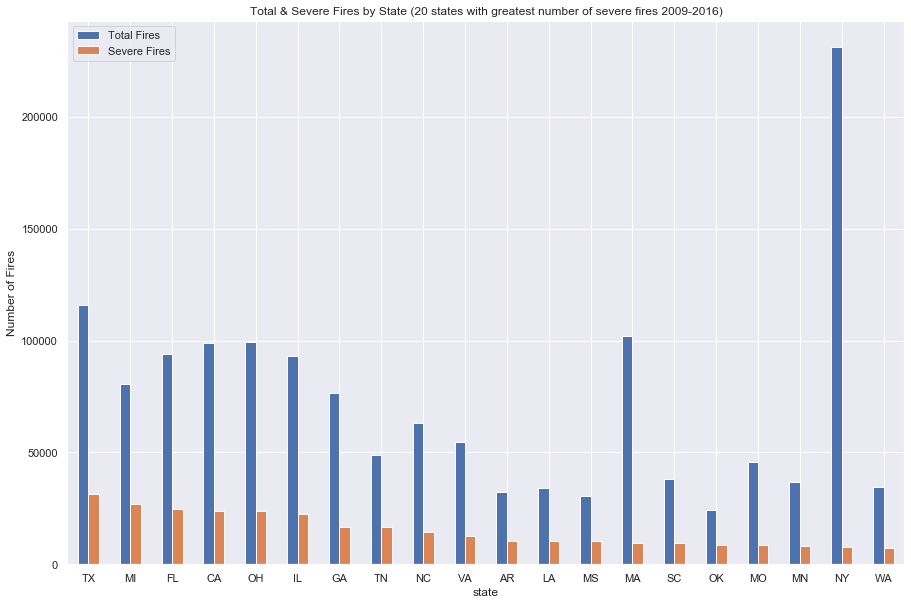

In [19]:
# Total & Severe fires by state, 2009-2016

state_fires = pd.crosstab(index=nfirs['state'],columns=nfirs['severe_fire'])
state_fires['total_fires'] = state_fires.sum(axis=1)

fig,ax1 = plt.subplots(1)
fig.set_size_inches((15,10))
state_fires[['total_fires','sev_fire']].sort_values('sev_fire',ascending=False)[:20].plot.bar(rot=0,ax=ax1)
ax1.set_title('Total & Severe Fires by State (20 states with greatest number of severe fires 2009-2016)')
ax1.set_ylabel('Number of Fires')
ax1.legend(['Total Fires','Severe Fires'])

In [20]:
top_10_states = state_fires['sev_fire'].sort_values(ascending=False)[:10].index

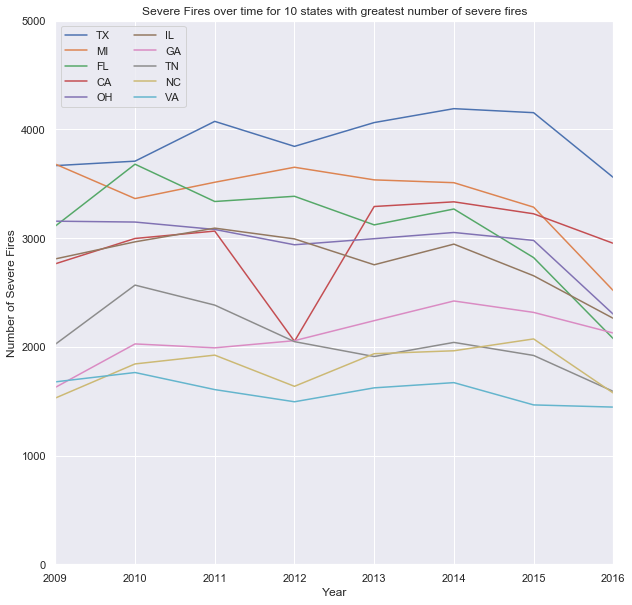

In [21]:
# Severe fires over time in worst states
state_fires_years = pd.crosstab(index=nfirs['state'],columns=[nfirs['year'],nfirs['severe_fire']])
years = list(range(2009,2017))

for year in years:
    state_fires_years[(year,'tot_fires')] = state_fires_years[(year,'not_sev_fire')] + state_fires_years[(year,'sev_fire')]

fig,ax = plt.subplots()
fig.set_size_inches(10,10)
sev_cols = [(year,'sev_fire') for year in range(2009,2017)]
# state_fires_years[sev_cols].sort_values((2016,'sev_fire'),ascending=False)[:10].transpose().plot(ax=ax)
state_fires_years[sev_cols].loc[top_10_states].transpose().plot(ax=ax)
ax.set_ylabel('Number of Severe Fires')
ax.set_xlabel('Year')
ax.set_title('Severe Fires over time for 10 states with greatest number of severe fires')
ax.set_ylim(0,5000)
plt.legend(loc='upper left',ncol=2)
a=ax.set_xticklabels(years)

# 4. Seasonal characteristics of severe & total fires

In [22]:
fires_by_date = pd.crosstab(index=nfirs['inc_date'],columns=nfirs['severe_fire'])
fires_by_date['tot_fires'] = fires_by_date.sum(axis=1)

In [23]:
# Check if there are any missing dates in the fires_by_date dataframe.
pd.date_range(start='2009-01-01',end='2016-12-31').difference(fires_by_date.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [24]:
fires_by_date['tot_rolling_30day_avg'] = fires_by_date['tot_fires'].rolling(window=30).sum().shift(-15)
fires_by_date['sev_rolling_30day_avg'] = fires_by_date['sev_fire'].rolling(window=30).sum().shift(-15)

Text(0.5, 1.0, 'USA: Centered, Rolling 30 day average of total fires')

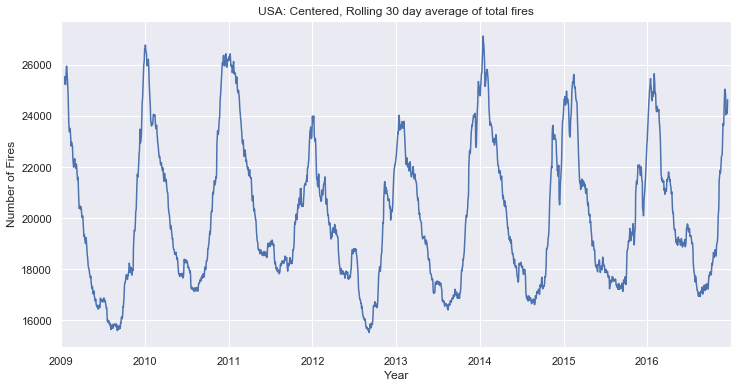

In [25]:
fig,ax1 = plt.subplots()
fig.set_size_inches(12,6)

fires_by_date['tot_rolling_30day_avg'].plot(ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Fires')
ax1.set_title('USA: Centered, Rolling 30 day average of total fires')

Text(0.5, 1.0, 'USA: Centered, Rolling 30 day average of severe fires')

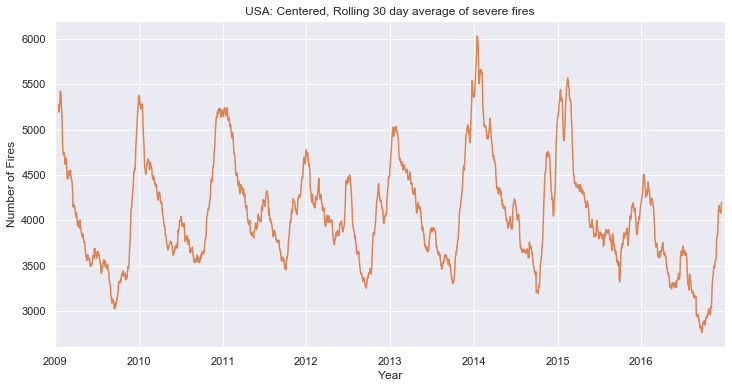

In [26]:
fig,ax2 = plt.subplots()
fig.set_size_inches(12,6)

fires_by_date['sev_rolling_30day_avg'].plot(ax=ax2,color=(221/255, 132/255, 82/255))
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Fires')
ax2.set_title('USA: Centered, Rolling 30 day average of severe fires')

# 4b. State fires by date

In [27]:
state_fires_by_date = pd.crosstab(index=nfirs['inc_date'],columns=[nfirs['state'],nfirs['severe_fire']])

states = state_fires_by_date.columns.get_level_values(0).unique()
for state in states:
    state_fires_by_date[(state,'tot_fires')] = state_fires_by_date[state].sum(axis=1)

for state in top_10_states:
    state_fires_by_date[(state,'30day_centered_avg')] = state_fires_by_date[(state,'sev_fire')].rolling(window=30).sum().shift(-15)

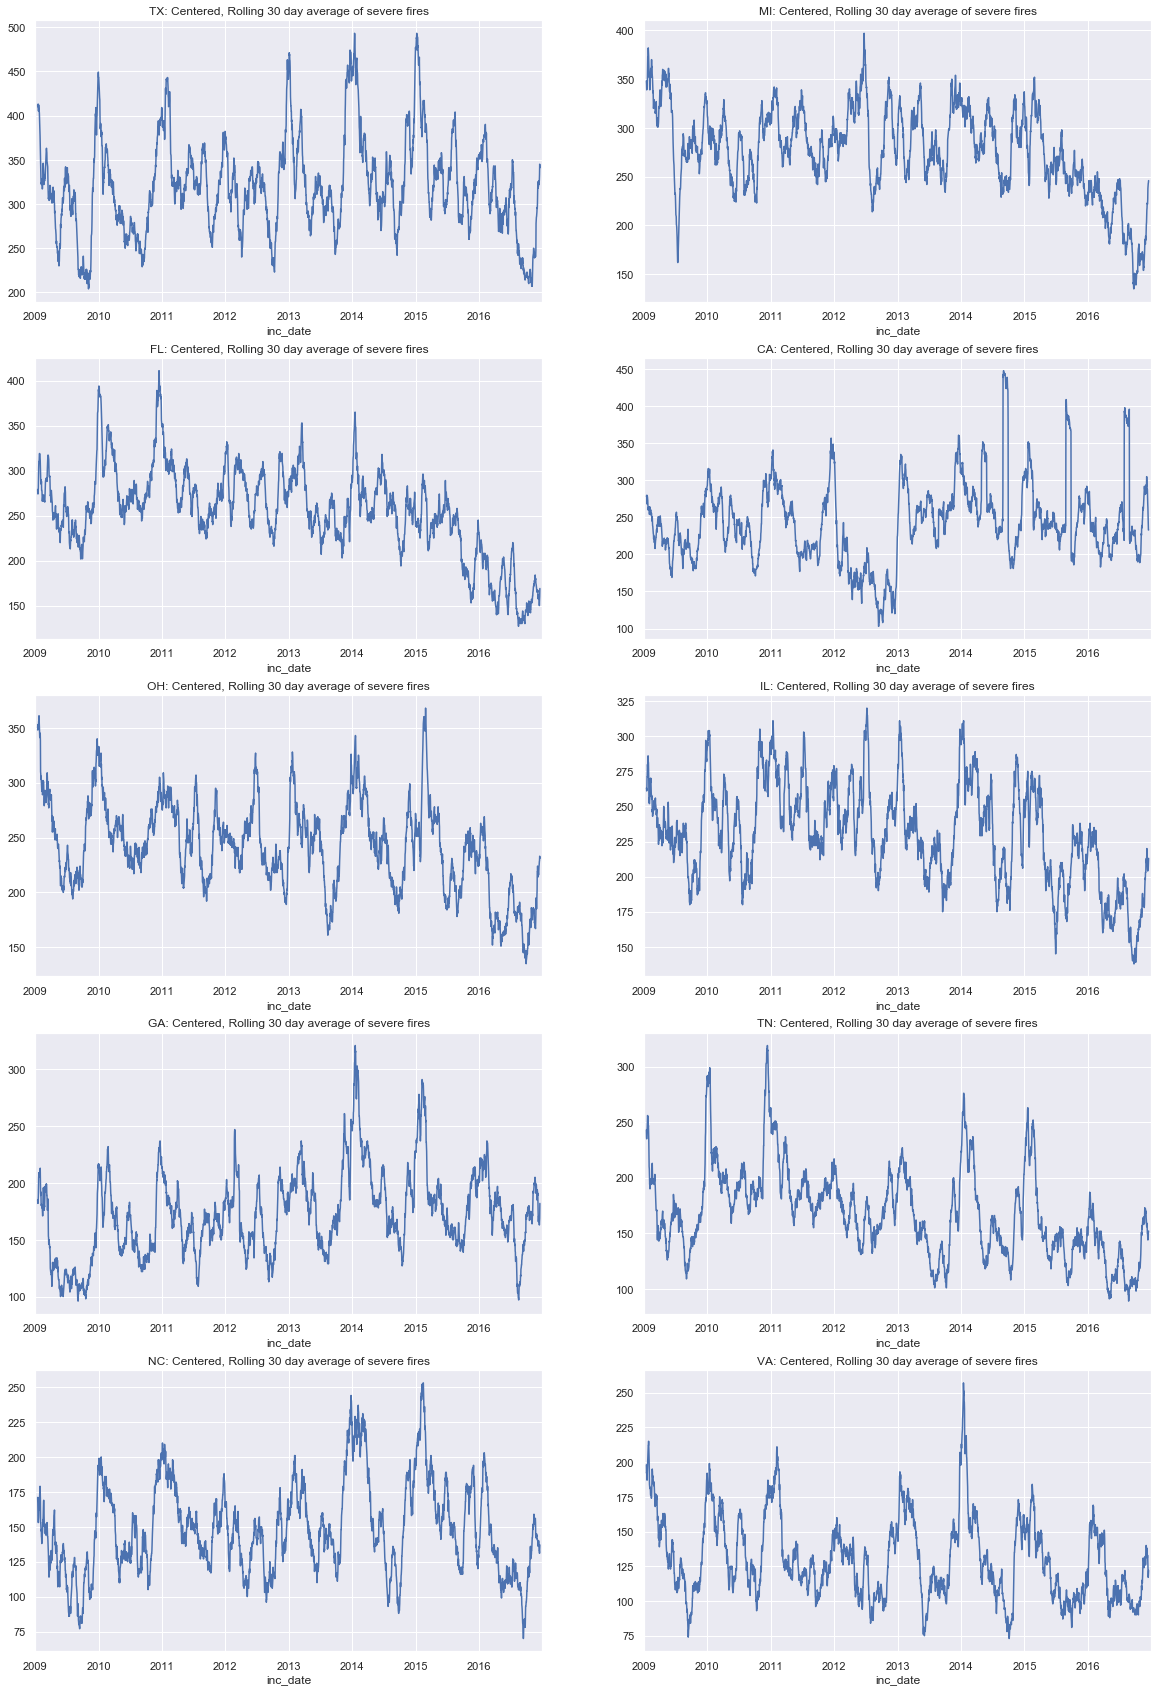

In [28]:
top_10_states_sev = [(state,'30day_centered_avg') for state in top_10_states]

fig,axes = plt.subplots(5,2)
fig.set_size_inches(20,30)

for state,ax in zip(top_10_states,fig.axes):
    state_fires_by_date[(state,'30day_centered_avg')].plot(ax=ax)
    ax.set_title(state + ': Centered, Rolling 30 day average of severe fires')